In [1]:
using JLD2
using PythonPlot
include("MDPModelFunctions2.jl")


    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonCall/wXfah/CondaPkg.toml
    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonPlot/f591M/CondaPkg.toml
    CondaPkg Dependencies already up to date


sim_exp1 (generic function with 1 method)

In [2]:
# row is 2 obj vs 4 obj
# col is pre-cue, neutral, retro-cue, neutral

cowan_k_true_7_yr = [1.16 1.14 1.13 1.02; 2.80 .91 1.30 .96]
cowan_k_true_adult = [1.98 1.94 1.97 1.95; 3.87 2.66 3.64 2.87]

2×4 Matrix{Float64}:
 1.98  1.94  1.97  1.95
 3.87  2.66  3.64  2.87

In [3]:
to_save_folder = "/home/erussek/projects/Memory_Models/shimi_1_run1"

function load_results(this_job_idx, epsilon, N_Quanta, NT_per_Second; on_cluster = false)
    
    if on_cluster
        to_save_folder = "/home/erussek/projects/Memory_Models/shimi_1_run1"
    else
        to_save_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/code/Memory_Models/shimi_1_run1"
    end
    
    local file_name = "Job_$(this_job_idx)_N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_per_Second_$(NT_per_Second).jld2"
    local full_file_path = joinpath(to_save_folder,file_name)

    res = load(full_file_path)
    
    return res["job_res"]
end

NT_per_Second = 25

d_all = load_results(1, 0.0, 2, NT_per_Second)

function get_model_cowan_k(d_all)
    part_pcorr = d_all[:,:,end]
    model_cowan_p_corr = [part_pcorr; part_pcorr[2,:]']'
    model_cowan_k = cowan_k(model_cowan_p_corr, 2)
    model_cowan_k[2,:] = cowan_k(model_cowan_p_corr[2,:], 4)
    
    return model_cowan_k
end

# get mean squared error for each setting...



get_model_cowan_k (generic function with 1 method)

Get MSE for each job

In [4]:

# 21 epsilon values
eps_vals = 0:.05:1
N_eps  = length(eps_vals)

# quanta values
q_vals = 2:2:40
N_q = length(q_vals)

# 
NT_vals = [25, 50, 100, 200, 400, 800]
N_nt = length(NT_vals)

job_eps = []
job_q = []
job_nt = []

job_eps_idx = []
job_q_idx = []
job_nt_idx = []

for (ep_idx, ep) in enumerate(eps_vals)
    for (q_idx, q) in enumerate(q_vals)
        for (nt_idx, nt) in enumerate(NT_vals)
            
            push!(job_eps, ep)
            push!(job_q, q)
            push!(job_nt, nt)
            
            push!(job_eps_idx, ep_idx)
            push!(job_q_idx, q_idx)
            push!(job_nt_idx, nt_idx)
            
        end
    end
end
n_jobs_total = length(job_nt)
job_idxs = 1:n_jobs_total

mse_7_yr = zeros(N_eps, N_q, N_nt)
mse_adult = zeros(N_eps, N_q, N_nt)

job_idx_mtx = zeros(N_eps, N_q, N_nt)

for this_job_idx in job_idxs
#this_job_idx = 1
    
    # ... #
    N_Quanta = job_q[this_job_idx]
    epsilon = job_eps[this_job_idx]
    NT_per_Second = job_nt[this_job_idx]
    
    N_Quanta_idx = job_q_idx[this_job_idx]
    epsilon_idx = job_eps_idx[this_job_idx]
    NT_per_Second_idx = job_nt_idx[this_job_idx]
    
    d_all = load_results(this_job_idx, epsilon, N_Quanta, NT_per_Second; on_cluster = false)
    cowan_k_model = get_model_cowan_k(d_all)
    
   mse_7_yr[epsilon_idx, N_Quanta_idx, NT_per_Second_idx] = sum((cowan_k_model .- cowan_k_true_7_yr).^2)
   mse_adult[epsilon_idx, N_Quanta_idx, NT_per_Second_idx] = sum((cowan_k_model .- cowan_k_true_adult).^2)
    job_idx_mtx[epsilon_idx, N_Quanta_idx, NT_per_Second_idx] = this_job_idx
end

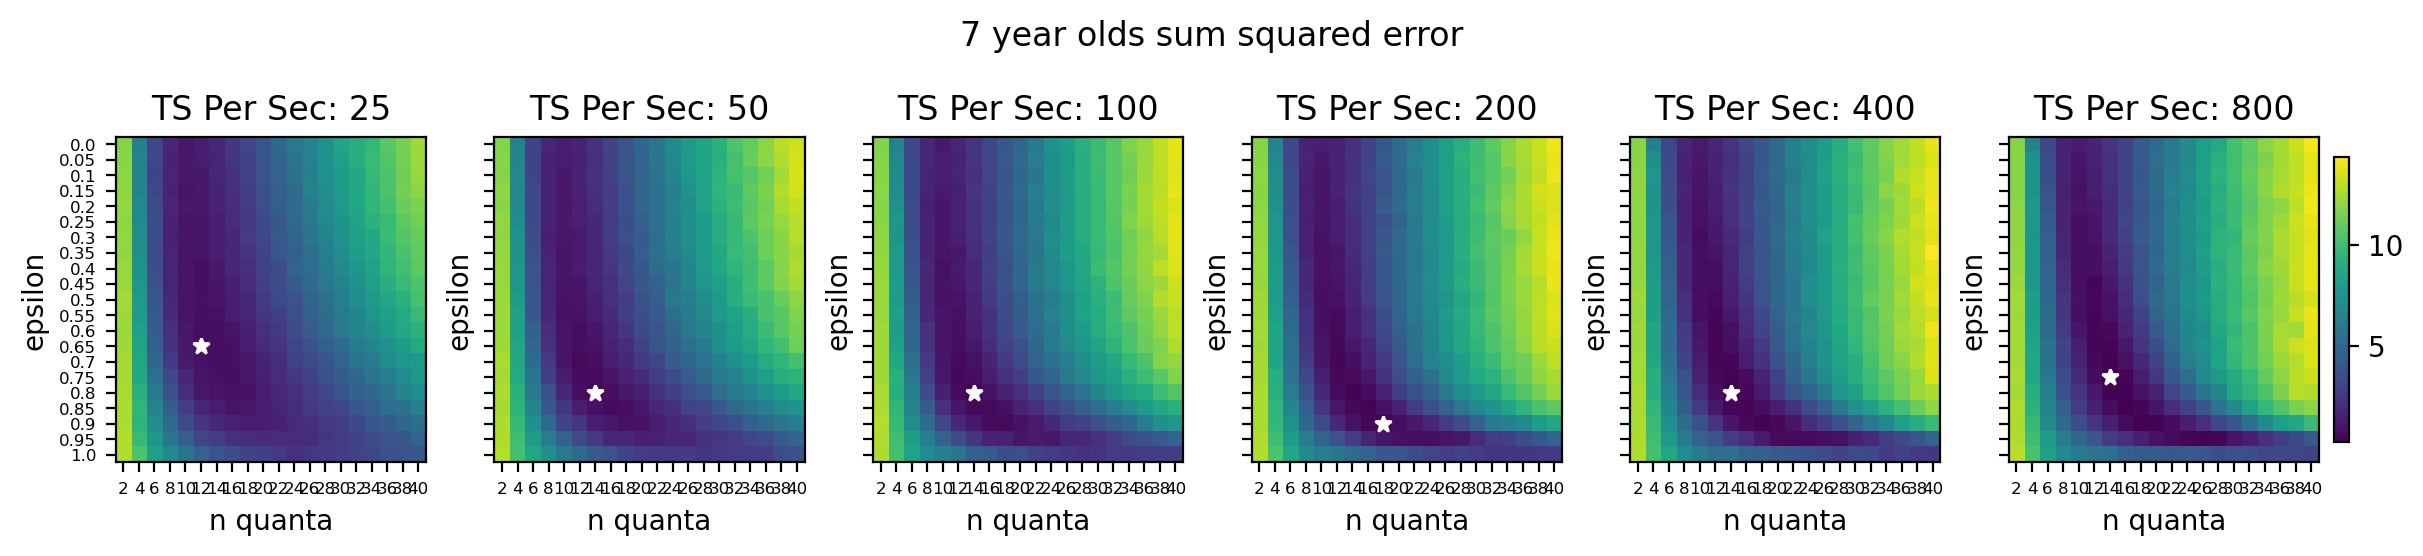

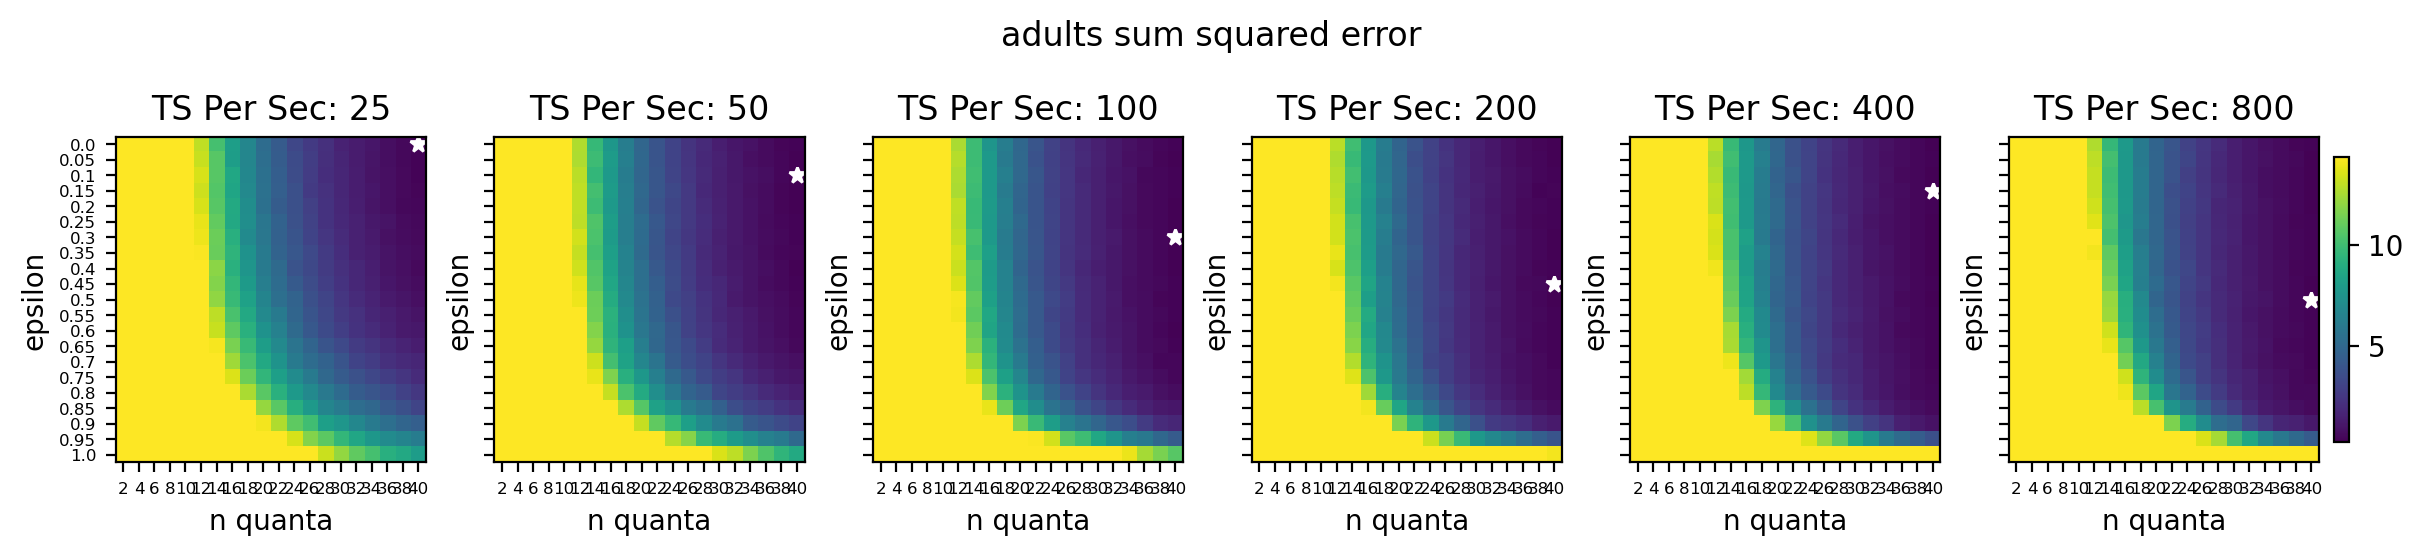

Python: Text(0.5, 0.85, 'adults sum squared error')

In [5]:
# plot some of these...


function plot_all_mse(this_mse; title = "7 year olds")

    vmin = minimum(mse_7_yr)
    vmax = maximum(mse_7_yr)

    fig,ax = subplots(1,6, figsize = (12,4), dpi=200,constrained_layout=true, sharey=true)
    for NT_idx = 1:N_nt
        c = ax[NT_idx-1].imshow(this_mse[:,:,NT_idx], vmin=vmin, vmax=vmax)
        min_idx = argmin(this_mse[:,:,NT_idx])
        ax[NT_idx-1].plot(min_idx[2]-1, min_idx[1]-1, '*', color = "white")


        #colorbar(c)
        ax[NT_idx-1].set_yticks(0:(N_eps-1))
        ax[NT_idx-1].set_yticklabels(eps_vals, fontsize=6)
        ax[NT_idx-1].set_xticks(0:(N_q-1))
        ax[NT_idx-1].set_xticklabels(q_vals, fontsize=6)
        ax[NT_idx-1].set_ylabel("epsilon")
        ax[NT_idx-1].set_xlabel("n quanta")
        ax[NT_idx-1].set_title("TS Per Sec: $(NT_vals[NT_idx])")

        if NT_idx == N_nt
            colorbar(c , fraction=0.046, pad=0.04)

        end
    end
    fig.suptitle(title * " sum squared error", y = .85)
end

plot_all_mse(mse_7_yr)
plot_all_mse(mse_adult, title = "adults")

# fig.tight_layout()

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(c, cax=cbar_ax)


In [6]:
# for each TS, get the min value for each, sum them together to 

# get best TS_per_sec index...

min_adult_sse_by_nt = zeros(N_nt)
min_7_yr_old_sse_by_nt = zeros(N_nt)

for NT_idx = 1:N_nt
    min_adult_sse_by_nt[NT_idx] = minimum(mse_adult[:,:,NT_idx])
    min_7_yr_old_sse_by_nt[NT_idx] = minimum(mse_7_yr[:,:,NT_idx])
end
both_sse_by_nt = min_adult_sse_by_nt .+ min_7_yr_old_sse_by_nt
best_nt_idx = argmin(both_sse_by_nt) # so 6 is the best... implies you should 

# now get best idxs for adults and 7 yr olds at this best_nt_idx
job_idxs_nt = job_idx_mtx[:,:,best_nt_idx]

best_NT = NT_vals[best_nt_idx]

# 1 is epsilon, 2 is n_quanta
best_adult_idxs = argmin(mse_adult[:,:,best_nt_idx])
best_adult_job_idx = Int(job_idxs_nt[best_adult_idxs])
adult_best_res = load_results(best_adult_job_idx, eps_vals[best_adult_idxs[1]], q_vals[best_adult_idxs[2]], NT_vals[best_nt_idx]; on_cluster = false)




best_7_yr_idxs = argmin(mse_7_yr[:,:,best_nt_idx])
best_7_yr_job_idx = Int(job_idxs_nt[best_7_yr_idxs])
ch_best_res = load_results(best_7_yr_job_idx, eps_vals[best_7_yr_idxs[1]], q_vals[best_7_yr_idxs[2]], NT_vals[best_nt_idx]; on_cluster = false);

In [14]:
adult_params = Dict()
adult_params["epsilon"] = eps_vals[best_adult_idxs[1]]
adult_params["N_Quanta"] = q_vals[best_adult_idxs[2]]

child_params = Dict()
child_params["epsilon"] = eps_vals[best_7_yr_idxs[1]]
child_params["N_Quanta"] = q_vals[best_7_yr_idxs[2]]

println(adult_params)
println(child_params)

Dict{Any, Any}("N_Quanta" => 40, "epsilon" => 0.5)
Dict{Any, Any}("N_Quanta" => 14, "epsilon" => 0.75)


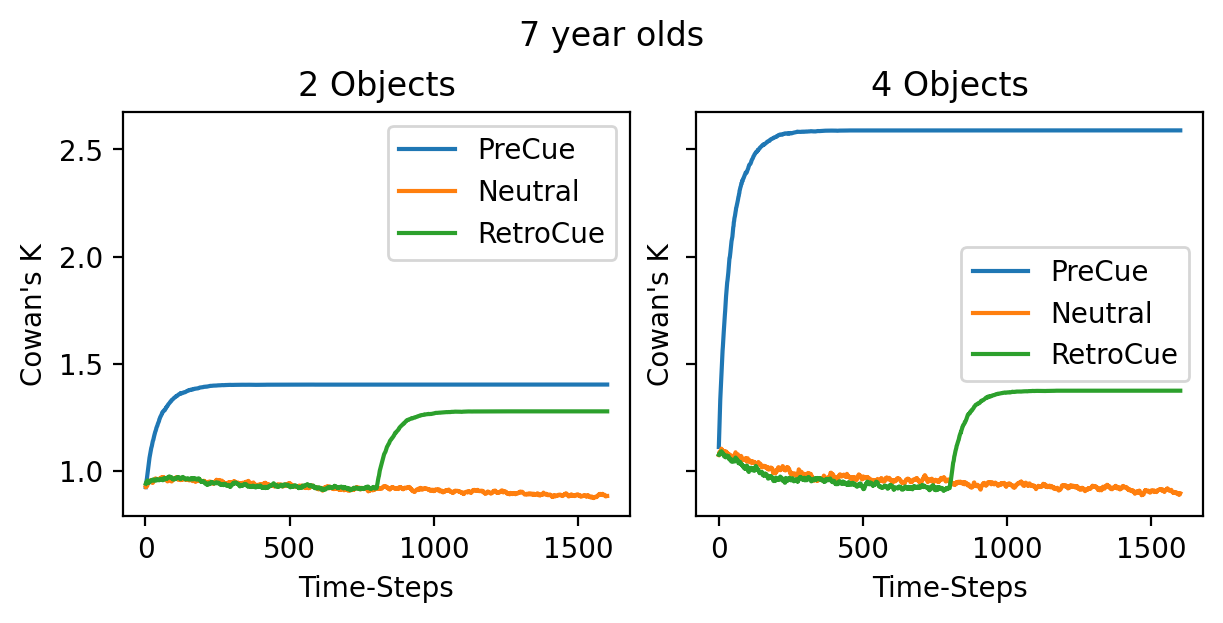

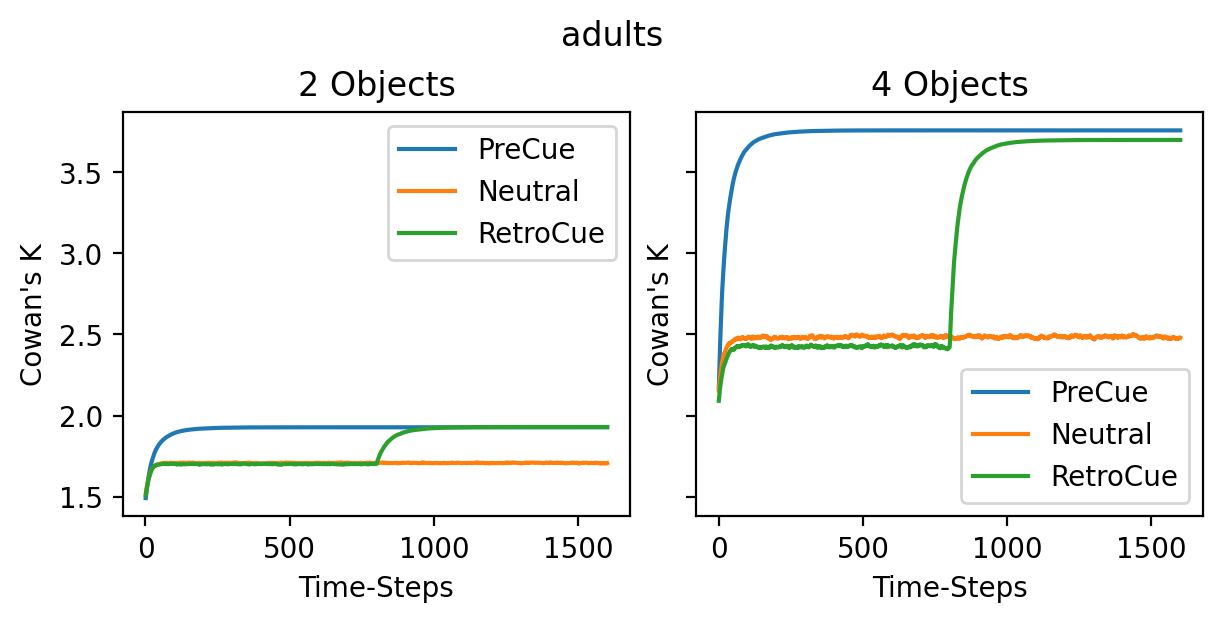

Python: Text(0.5, 0.98611, 'adults')

In [8]:
function plot_over_time(d_all, NT_per_Second; title = "")

    fig,ax = subplots(1, 2, figsize = (6,3), dpi=200,constrained_layout=true, sharey=true)

    N_TimeSteps = 2*NT_per_Second

    for (obj_idx, N_Objects) in enumerate([2,4])

        TS = 1:N_TimeSteps

        d_precue = cowan_k(d_all[1,obj_idx,:], N_Objects);
        ax[obj_idx-1].plot(TS, d_precue, label = "PreCue")

        d_neutral = cowan_k(d_all[2,obj_idx,:], N_Objects);
        ax[obj_idx-1].plot(TS, d_neutral, label = "Neutral")

        d_retro = cowan_k(d_all[3,obj_idx,:], N_Objects);
        ax[obj_idx-1].plot(TS, d_retro, label = "RetroCue")
        ax[obj_idx-1].legend()
        ax[obj_idx-1].set_xlabel("Time-Steps")

        ax[obj_idx-1].set_ylabel("Cowan's K")

        ax[obj_idx-1].set_title(string(N_Objects) * " Objects")

    end
    fig.suptitle(title)
end
plot_over_time(ch_best_res, best_NT; title = "7 year olds")
plot_over_time(adult_best_res, best_NT; title = "adults")

In [9]:
# row is 2 obj vs 4 obj
# col is pre-cue, neutral, retro-cue, neutral
# row is 2 obj vs 4 obj
# col is pre-cue, neutral, retro-cue, neutral

#cowan_k_true_7_yr = [1.16 1.14 1.13 1.02; 2.80 .91 1.30 .96]
#cowan_k_true_adult = [1.98 1.94 1.97 1.95; 3.87 2.66 3.64 2.87]
cowan_k_model_7_yr = get_model_cowan_k(ch_best_res)
cowan_k_model_adult = get_model_cowan_k(adult_best_res)


2×4 Matrix{Float64}:
 1.92803  1.70673  1.92999  1.70673
 3.75789  2.48005  3.69899  2.48005

In [10]:
function plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")
    x_vals = Vector(1:4) .- .2
    y_vals = [this_cowan_k[1,[1 3]] this_cowan_k[2,[1 3]]]
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:4) .+ .2
    y_vals = [this_cowan_k[1,[2 4]] this_cowan_k[2,[2 4]]]
    ax.bar(x_vals, y_vals, .4, label = "Neutral")

    ax.set_xticks(1:4)
    ax.set_xticklabels(["Load2Pre", "Load2Retro", "Load4Pre", "Load4Retro"], rotation = 90)
    ax.set_xlabel(group_name)
    ax.set_ylabel("Cowan's K")
end




plot_cowan_k_bars (generic function with 1 method)

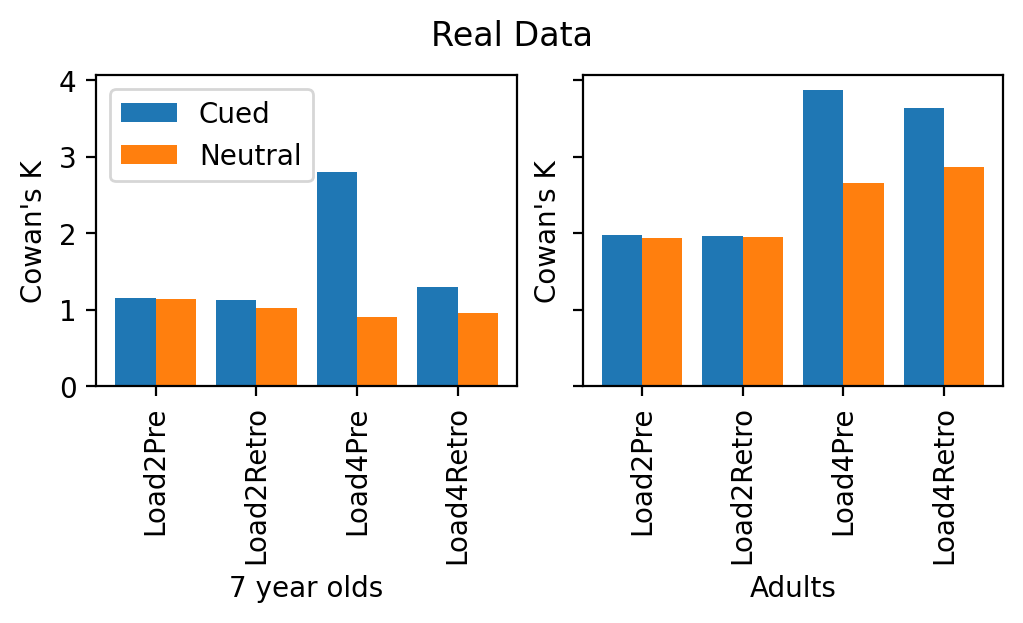

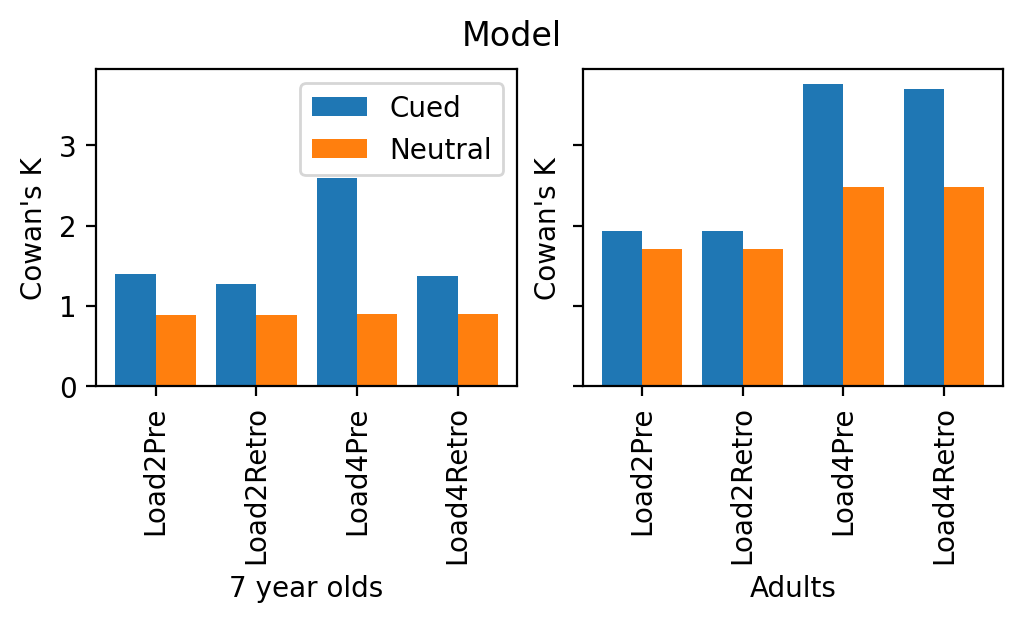

Python: Text(0.5, 0.98611, 'Model')

In [11]:
fig,ax = subplots(1, 2,  figsize = (5,3), dpi=200,constrained_layout=true, sharey=true)

plot_cowan_k_bars(cowan_k_true_7_yr, ax[0])
plot_cowan_k_bars(cowan_k_true_adult, ax[1], group_name = "Adults")
ax[0].legend()
fig.suptitle("Real Data")

fig,ax = subplots(1, 2,  figsize = (5,3), dpi=200,constrained_layout=true, sharey=true)

plot_cowan_k_bars(cowan_k_model_7_yr, ax[0])
plot_cowan_k_bars(cowan_k_model_adult, ax[1], group_name = "Adults")
ax[0].legend()
fig.suptitle("Model")
